# Exploratory Data Analysis

## Aims and Description of Data

Data on the performance of internationally competing dressage horses were scraped from the web into a SQLite database using the Python scrapy library and cleaned in R. The database has two tables for the cleaned data: one for pedigree data and the other for show results. Show scores for non-completion (withdrawn, eliminated, disqualified, retired) are imputed. The aim of this exploratory data analysis was to explore relationships between variables in the data and play around with creating features that might explain mean lifetime show score. Some of the features that I'd like to look at are:
- Those already present e.g. sex, year of birth
- Number of shows eliminated/disqualified/withdrawn/retired
- Number of offspring 
- Sire (binary)
- Number of shows 
- Number of riders per horse/number of horses per rider
- Mean score of offspring


In [67]:
library(RSQLite, quietly = T)
library(tidyverse, quietly = T)

conn <- dbConnect(RSQLite::SQLite(), "dressage.db")

ped <- dbGetQuery(conn, 'SELECT * FROM clean_pedigree')
shows <- dbGetQuery(conn, 'SELECT * FROM clean_shows')

The `ped` table contains sire data on 968 horses. It contains 186 sires. Each row represents a horse.

In [68]:
dim(ped)

# can merge sire IDs into 1 as none have a UELN and an ID
sum(!is.na(ped$sire_id) & !is.na(ped$sire_ueln))

ped <- ped %>%
    mutate(sire = coalesce(sire_id, sire_ueln))

length(unique(ped$sire))

[1] 968   6

[1] 0

[1] 186

This sire data can be related to 16,173 show results through `horse_id`. Each row represents a show result for some horse-rider combination. 

In [69]:
dim(shows)

[1] 16173    11

I create three seperate show tables with different groupings: horse-rider combination, horse only, and rider only.

In [70]:
comb_shows <- shows %>%
    mutate(comb = paste(horse_id, rider_id)) %>%
    group_by(comb) %>%
    mutate(mean_score = mean(score)) %>%
    mutate(num_el = sum(position == "EL")) %>%
    mutate(num_wd = sum(position == "WD")) %>%
    mutate(num_dsq = sum(position == "DSQ")) %>%
    mutate(num_ret = sum(position == "RET")) %>%
    mutate(non_comp = num_el + num_wd + num_dsq + num_ret) %>%
    mutate(num_shows = n())

horse_shows <- shows %>%
    group_by(horse_id) %>%
    mutate(mean_score = mean(score)) %>%
    mutate(num_el = sum(position == "EL")) %>%
    mutate(num_wd = sum(position == "WD")) %>%
    mutate(num_dsq = sum(position == "DSQ")) %>%
    mutate(num_ret = sum(position == "RET")) %>%
    mutate(non_comp = num_el + num_wd + num_dsq + num_ret) %>%
    mutate(num_shows = n())

rider_shows <- shows %>%
    group_by(rider_id) %>%
    mutate(mean_score = mean(score)) %>%
    mutate(num_el = sum(position == "EL")) %>%
    mutate(num_wd = sum(position == "WD")) %>%
    mutate(num_dsq = sum(position == "DSQ")) %>%
    mutate(num_ret = sum(position == "RET")) %>%
    mutate(non_comp = num_el + num_wd + num_dsq + num_ret) %>%
    mutate(num_shows = n())

I then joined the horse-rider combination table to the pedigree table to obtain sire information for the horses. The mean number of riders per horse was 1.325, and the mean number of horses per rider was 1.386.

In [71]:
sires <- unique(ped$sire)

ped <- ped %>%
    filter(horse_id %in% shows$horse_id) %>%
    mutate(is_sire = ifelse((horse_ueln %in% sires & !is.na(horse_ueln)) | (horse_id %in% sires & !is.na(horse_id)), T, F)) %>%
    rowwise() %>%
    mutate(num_offspring = sum(horse_ueln == ped$sire, na.rm = T) + sum(horse_id == ped$sire, na.rm = T))

combs <- comb_shows %>%
    inner_join(ped, by = "horse_id") %>%
    select(comb, rider_id, horse_id, horse_ueln, sex = sex.x, yob = yob.x, num_shows, sire, mean_score, num_el, num_ret, num_dsq, num_wd, non_comp, num_offspring, is_sire) %>%
    distinct()

head(combs)

comb,rider_id,horse_id,horse_ueln,sex,yob,num_shows,sire,mean_score,num_el,num_ret,num_dsq,num_wd,non_comp,num_offspring,is_sire
102ZI90 10011389,10011389,102ZI90,276433330826405,0,2005,144,276333332243993,84.63854,0,0,0,0,0,0,FALSE
103CM31 10011389,10011389,103CM31,276441411396304,0,2004,33,276343430476299,81.45452,0,0,0,0,0,0,FALSE
103HX90 10023552,10023552,103HX90,276431310648406,1,2006,78,276333330471993,78.74418,0,0,0,2,2,0,FALSE
105AH62 10010680,10010680,105AH62,276409090042107,0,2007,56,276409090081903,78.62424,2,0,0,0,2,0,FALSE
DEN40739 10019441,10019441,DEN40739,208333200301452,1,2003,46,276309090304085,79.45720,0,0,0,0,0,0,FALSE
105BZ34 10028440,10028440,105BZ34,276431310562909,0,2009,21,276341410479692,80.86129,1,0,0,0,1,0,FALSE


In [72]:
mean(table(combs$horse_id))

rider_count <- horse_shows %>% 
    select(horse_id, rider_id) %>%
    distinct() %>%
    count(horse_id)

horses <- horse_shows %>%
    inner_join(ped, by = "horse_id") %>%
    select(horse_id, horse_ueln, sex = sex.x, yob = yob.x, num_shows, sire, mean_score, num_el, num_ret, num_dsq, num_wd, non_comp, num_offspring, is_sire) %>%
    distinct() %>%
    mutate(num_riders = sum(horse_id == combs$horse_id))

sires <- horses$sire
sires[is.na(sires)] <- 0

horses <- horses %>%
    mutate(off_score = case_when(is_sire == F ~ NA_real_,
                                 is_sire == T ~ mean(horses[sires == horse_ueln | sires == horse_id,]$mean_score, na.rm = T)))


head(horses)

[1] 1.32475

horse_id,horse_ueln,sex,yob,num_shows,sire,mean_score,num_el,num_ret,num_dsq,num_wd,non_comp,num_offspring,is_sire,num_riders,off_score
102ZI90,276433330826405,0,2005,144,276333332243993,84.63854,0,0,0,0,0,0,FALSE,1,NA
103CM31,276441411396304,0,2004,33,276343430476299,81.45452,0,0,0,0,0,0,FALSE,1,NA
103HX90,276431310648406,1,2006,78,276333330471993,78.74418,0,0,0,2,2,0,FALSE,1,NA
105AH62,276409090042107,0,2007,56,276409090081903,78.62424,2,0,0,0,2,0,FALSE,1,NA
DEN40739,208333200301452,1,2003,46,276309090304085,79.45720,0,0,0,0,0,0,FALSE,1,NA
105BZ34,276431310562909,0,2009,21,276341410479692,80.86129,1,0,0,0,1,0,FALSE,1,NA


In [73]:
mean(table(combs$rider_id))

horse_count <- rider_shows %>% 
    select(horse_id, rider_id) %>%
    distinct() %>%
    count(rider_id)

riders <- rider_shows %>%
    select(rider_id, mean_score, num_el, num_wd, num_dsq, num_ret, non_comp, num_shows) %>%
    distinct() %>%
    mutate(no_horse = horse_count[horse_count$rider_id == rider_id,]$n)

head(riders)

[1] 1.386228

rider_id,mean_score,num_el,num_wd,num_dsq,num_ret,non_comp,num_shows,no_horse
10011389,81.28997,1,0,0,0,1,332,7
10023552,76.43235,0,2,0,0,2,269,7
10010680,77.08550,2,0,0,1,3,163,4
10019441,78.58604,0,0,0,0,0,68,3
10028440,79.13670,1,0,0,0,1,46,3
10012844,80.69745,0,0,0,1,1,152,5


I will split the rest of this notebook into looking at each of these three dataframes for potentially informative trends. 

## Horse-Rider Combinations

First, I had a look at the distributions of each continuous data type present for combinations. Mean dressage score per combination appears to be approximately normally distributed with some right skew. Number of shows per combination is typically very low. It is especially uncommon for combinations to have competed in over 50 shows together. Additionally, most combinations complete ever show they enter. There is a single combination that failed to complete 10 shows.

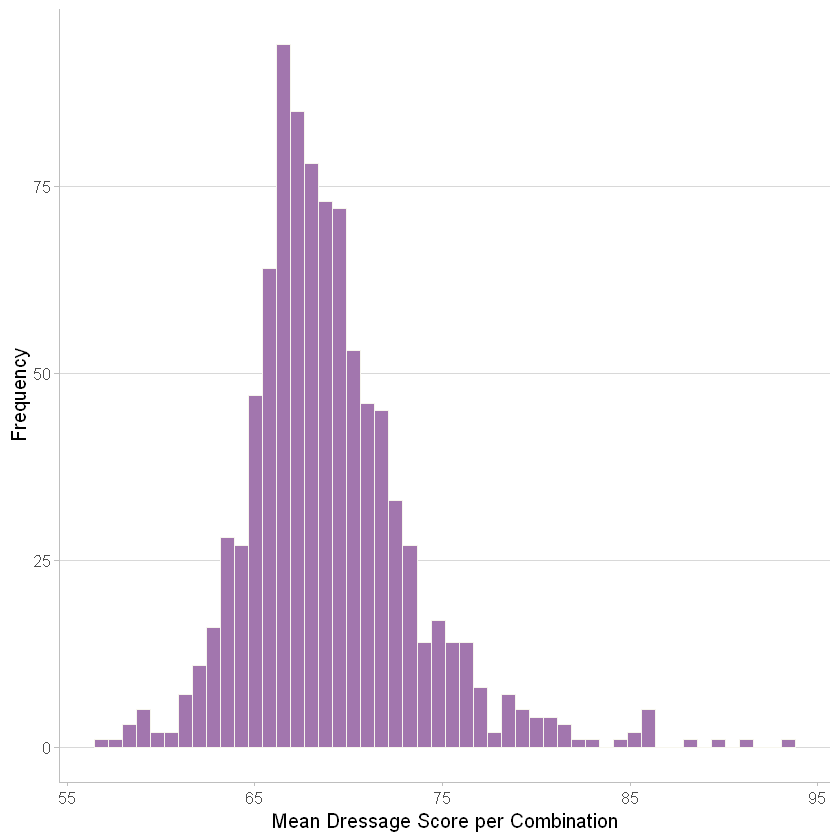

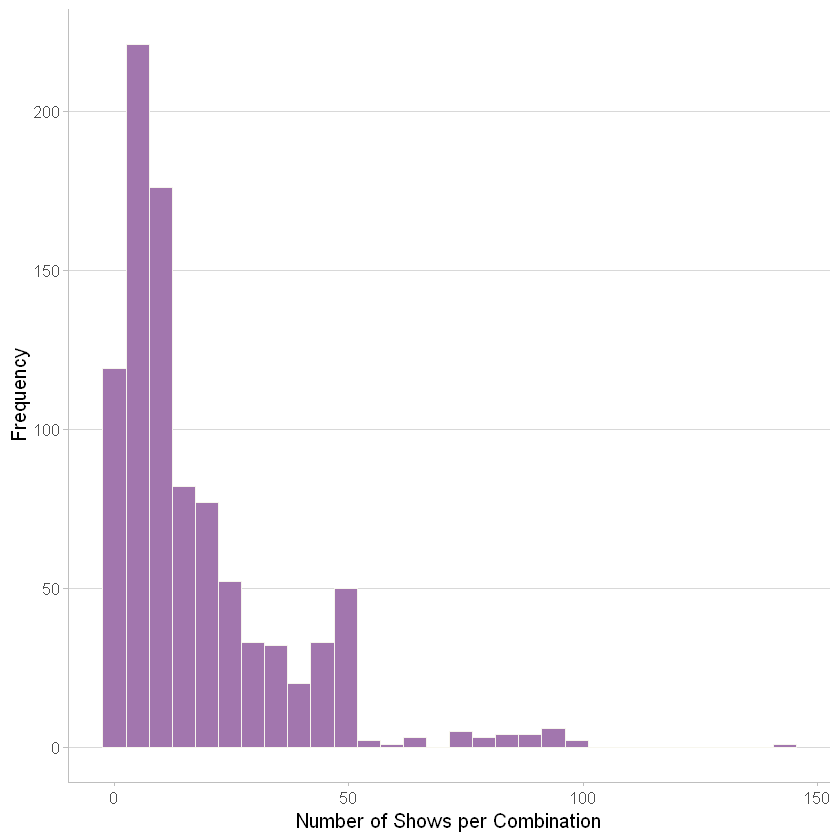

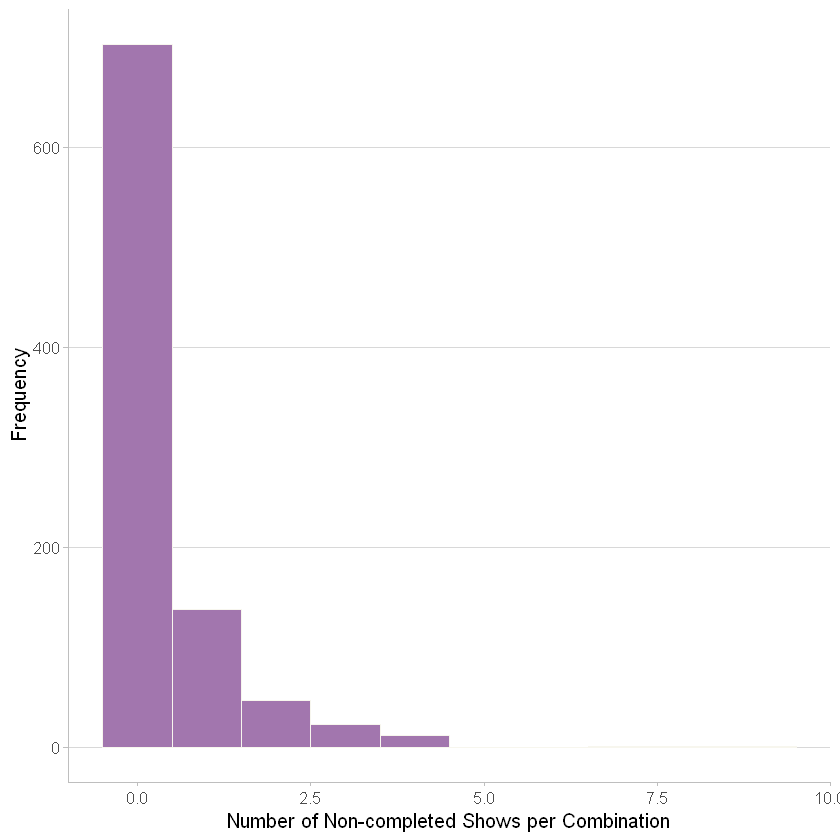

In [74]:
library(ggthemes, quietly = T)

theme_fei <- function() {
  theme_hc(base_size = 12) %+replace%
    theme(panel.background  = element_blank(),,
          axis.ticks = element_line(colour = "grey"),
          axis.line = element_line(color = "grey"))
}

plotHistogram <- function(col, df, num_bins, label) {
    ggplot(aes(x = !!sym(col)), data = df) + 
      geom_histogram(fill = "#A276AE", color = "#F7F6EE", bins = num_bins) + 
      labs(x = label, y = "Frequency") + 
      theme_fei()
}

plotHistogram("mean_score", combs, 50, "Mean Dressage Score per Combination")
plotHistogram("num_shows", combs, 30, "Number of Shows per Combination")
plotHistogram("non_comp", combs, 10, "Number of Non-completed Shows per Combination")


Next I examine some relationships that may be interesting. The most obvious would be the relationship between the number of shows and mean dressage score. This takes a funnel shape: which might suggest that mean score regresses towards the population mean as the number of shows increases. This could be statistical: individuals who have competed in fewer shows will have means more easily affected by extreme values. Nevertheless, there do appear to be some individuals that perform very well, even after competing in many shows.

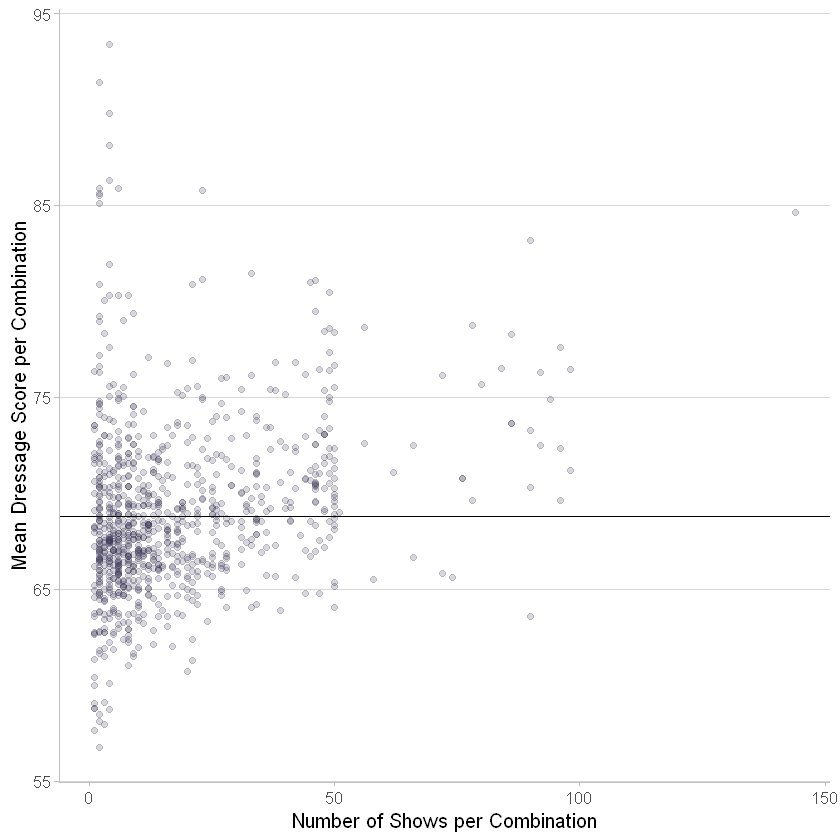

In [75]:
ggplot(aes(y = mean_score, x = num_shows), data = combs) +
  geom_point(color = "#363151", alpha = 0.2) + 
  labs(x = "Number of Shows per Combination", y = "Mean Dressage Score per Combination") +
  theme_fei() + 
  geom_abline(slope = 0, intercept = 68.81721)

By eye, there doesn't appear to be any relationship between how many shows a combination has competed in and how many shows they fail to complete.

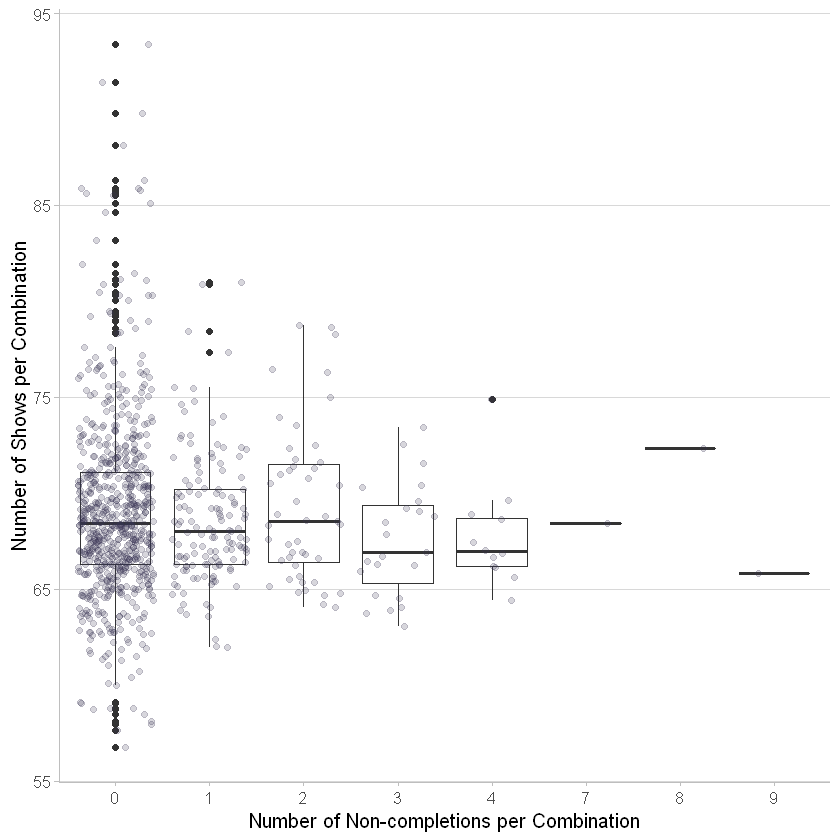

In [76]:
combs[['non_comp']] <- as.factor(combs[['non_comp']])

ggplot(aes(y = mean_score, x = non_comp), data = combs) +
  geom_boxplot() +
  geom_jitter(color = "#363151", alpha = 0.2) + 
  labs(y = "Number of Shows per Combination", x = "Number of Non-completions per Combination") +
  theme_fei()

## Horses

As most horses present with only a single rider, and vice versa, it is unsurprising to observe that the distributions of mean score, number of shows, and non-completion are very similar to how they were for horse-rider combination.

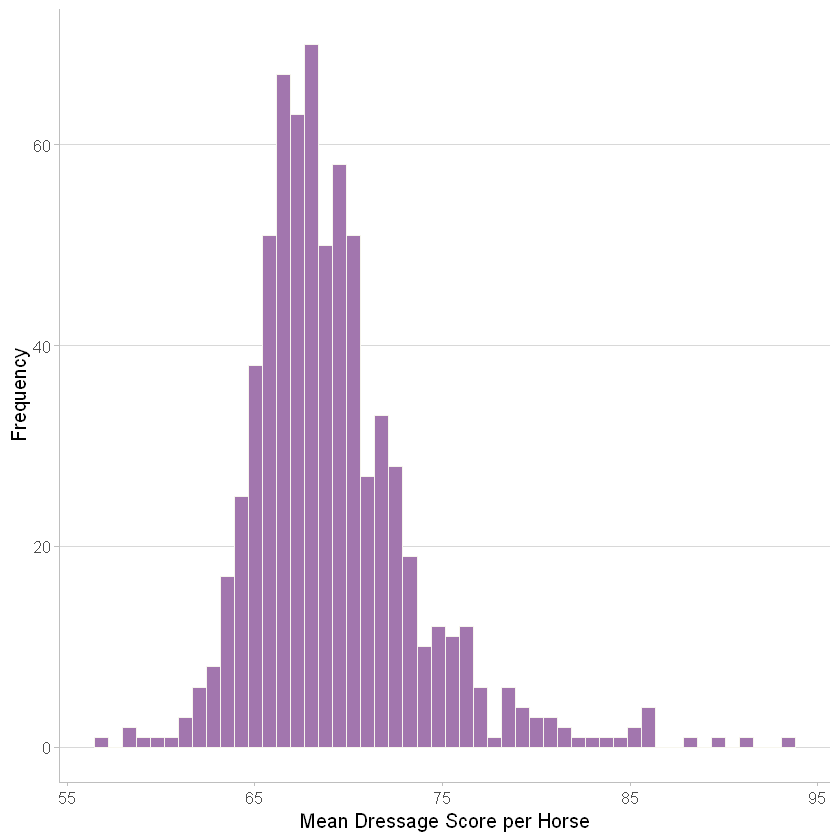

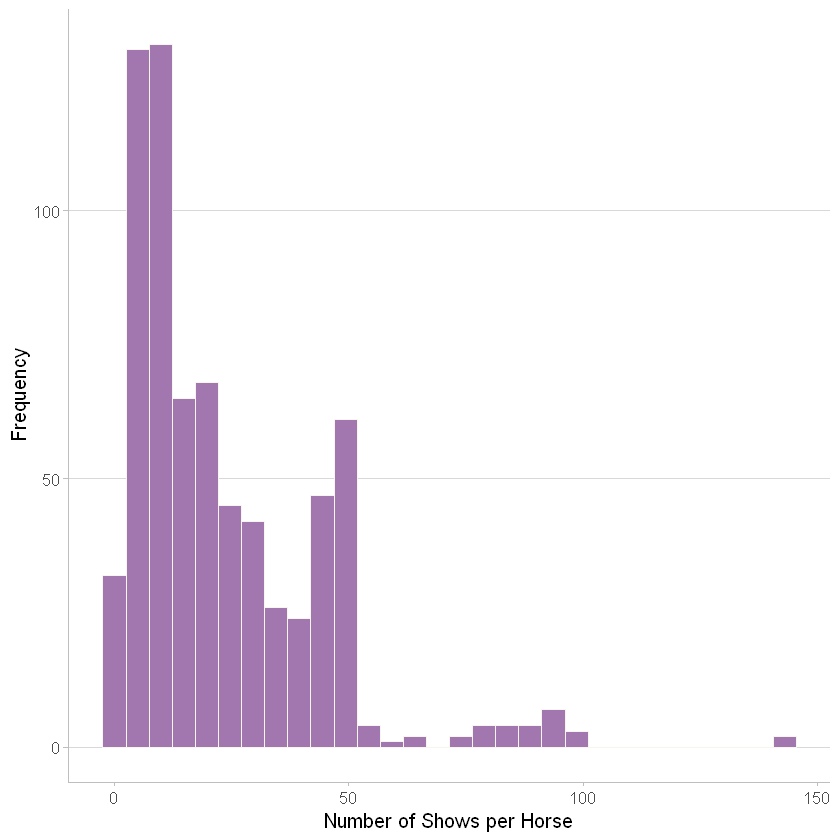

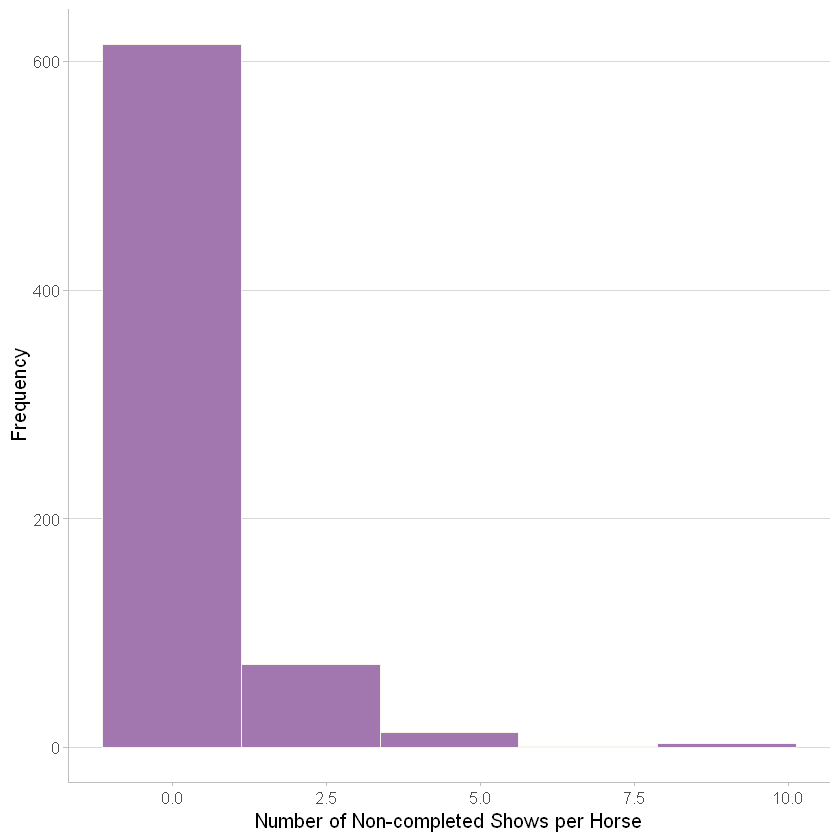

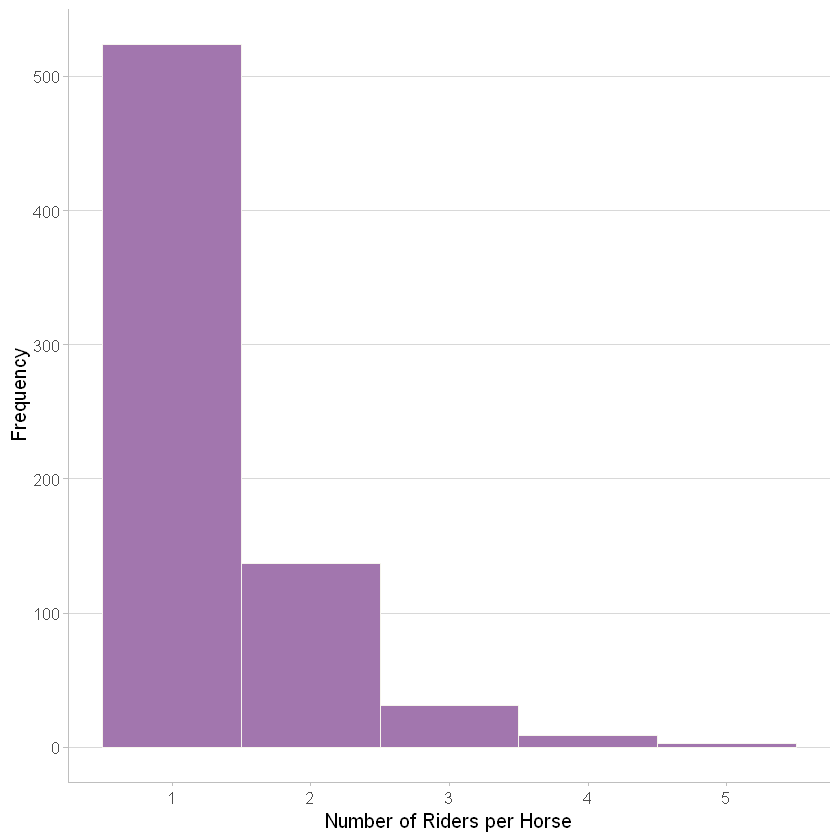

In [86]:
plotHistogram("mean_score", horses, 50, "Mean Dressage Score per Horse")
plotHistogram("num_shows", horses, 30, "Number of Shows per Horse")
plotHistogram("non_comp", horses, 5, "Number of Non-completed Shows per Horse")
plotHistogram("num_riders", horses, 5, "Number of Riders per Horse")

I observe the same funnel shape as for combinations: horses who have competed in just a few shows have much greater variance in their mean score. Interestingly, horses born very recently appear to have higher scores. This could be because they have competed in fewer shows, and by chance have obtained high scores. However, it could be some real effect where young horses achieve higher scores than older horses. The number of riders a horse has had throughout its career doesn't seem to affect correlate with its mean dressage score.

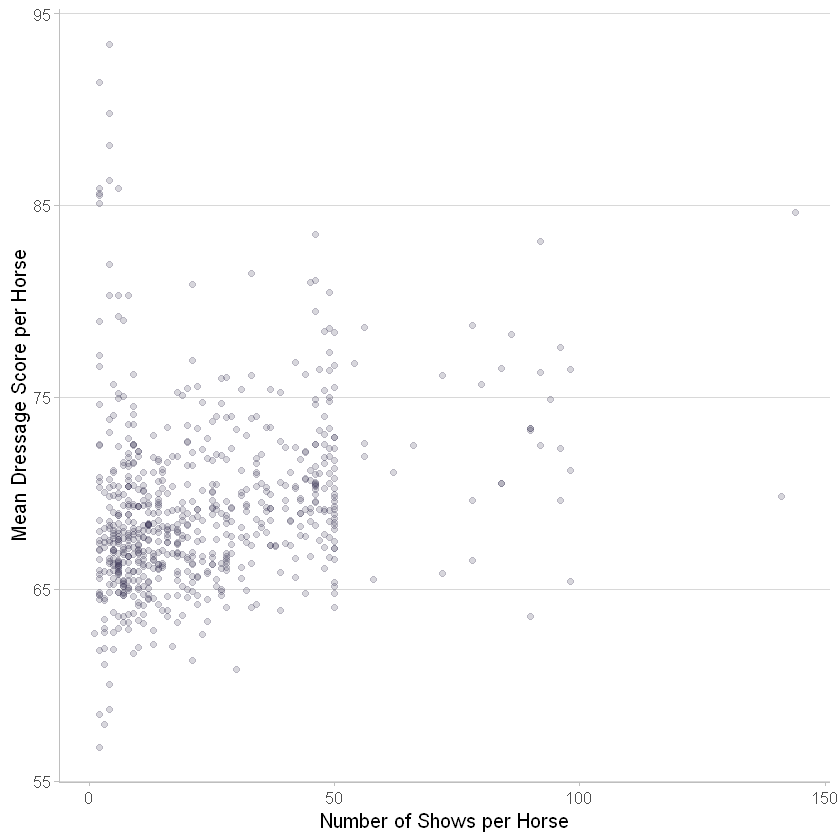

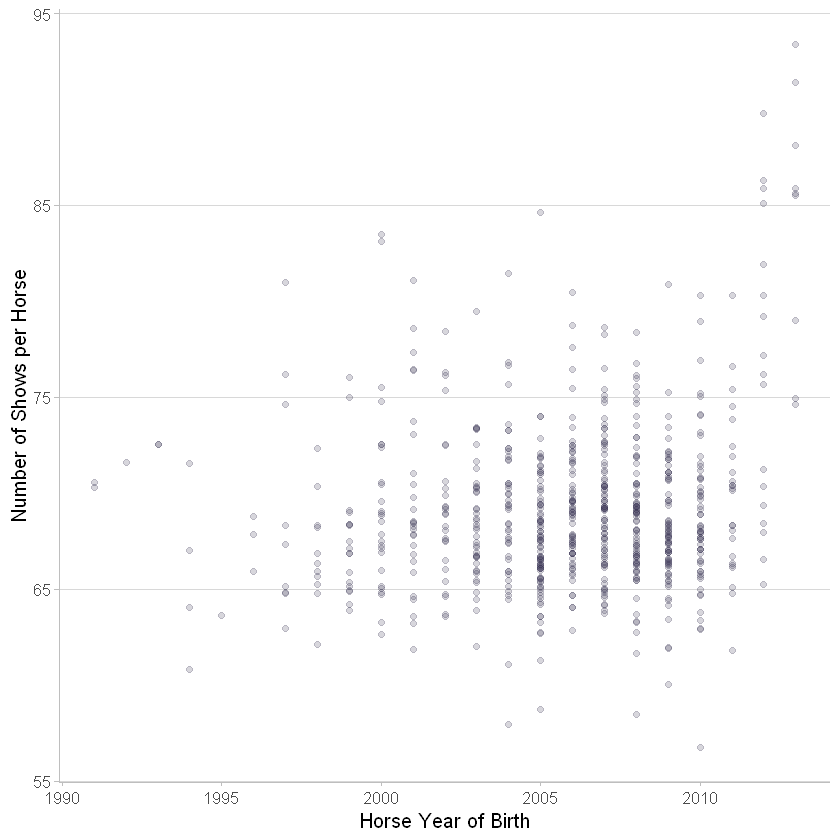

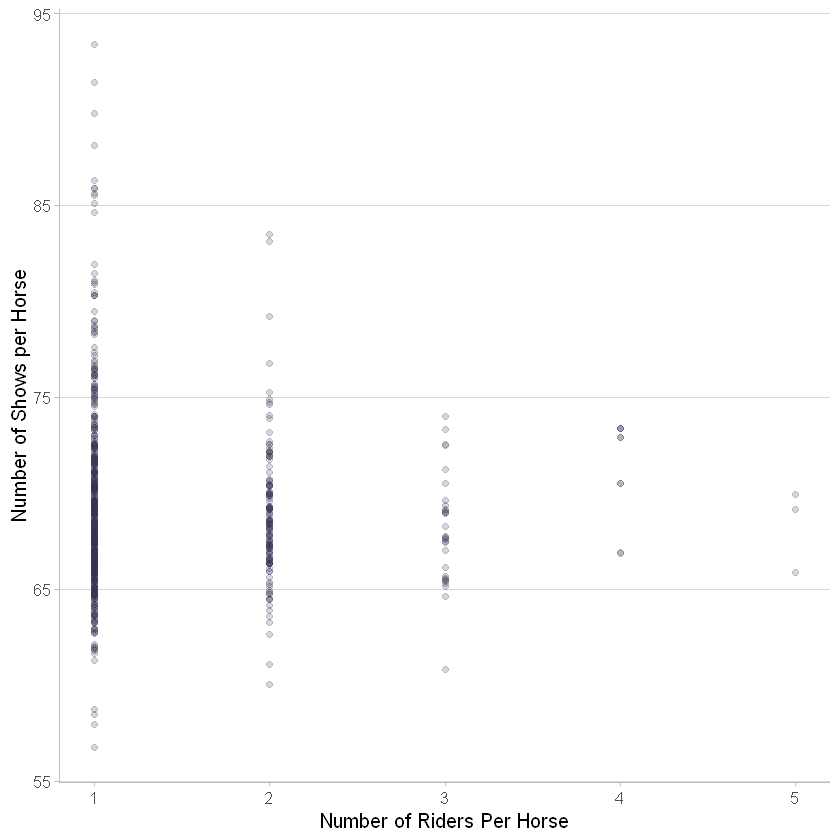

In [87]:
ggplot(aes(y = mean_score, x = num_shows), data = horses) +
  geom_point(color = "#363151", alpha = 0.2) + 
  labs(x = "Number of Shows per Horse", y = "Mean Dressage Score per Horse") +
  theme_fei()

ggplot(aes(y = mean_score, x = yob), data = horses) +
  geom_point(color = "#363151", alpha = 0.2) + 
  labs(y = "Number of Shows per Horse", x = "Horse Year of Birth") +
  theme_fei()

ggplot(aes(y = mean_score, x = num_riders), data = horses) +
  geom_point(color = "#363151", alpha = 0.2) + 
  labs(y = "Number of Shows per Horse", x = "Number of Riders Per Horse") +
  theme_fei()

Below I have plotted mean score against whether or not a male horse is a sire of another horse in the dataset. We might expect that only successful sires would be picked for breeding, or that those who are not sires may be gelded, and gelding might affect performance. Questions like these highlight the limitations of this dataset: we cannot distinguish between the two different scenarios I mentioned, and we also cannot be sure we captured all of the offspring of any individual, as the individual may have had offspring that were never registered with the FEI.

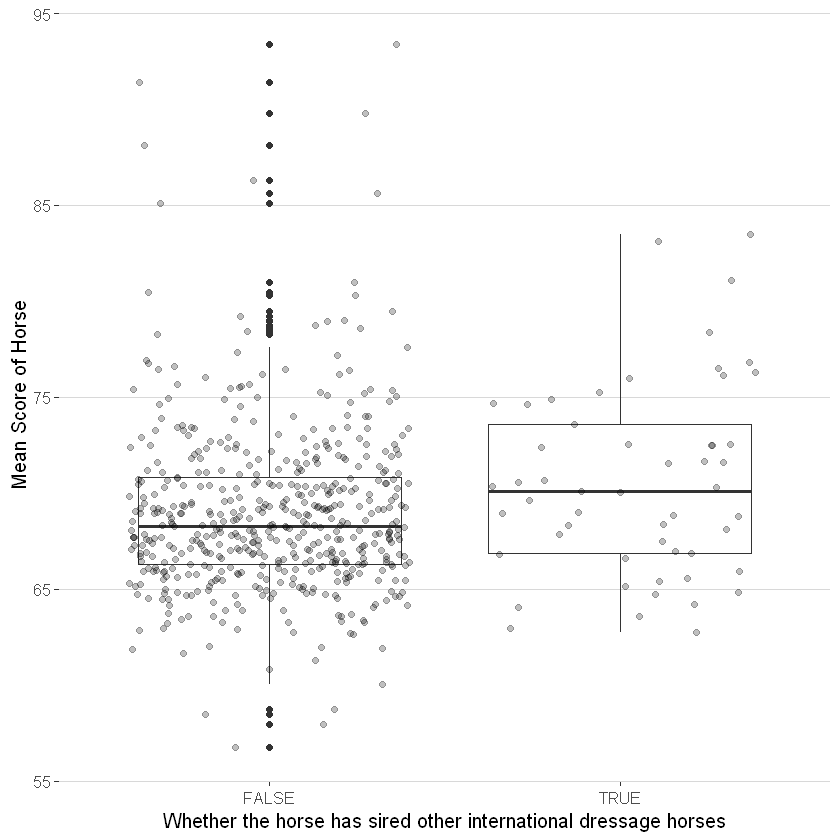

Warning message:
"Removed 4 rows containing missing values (geom_point)."

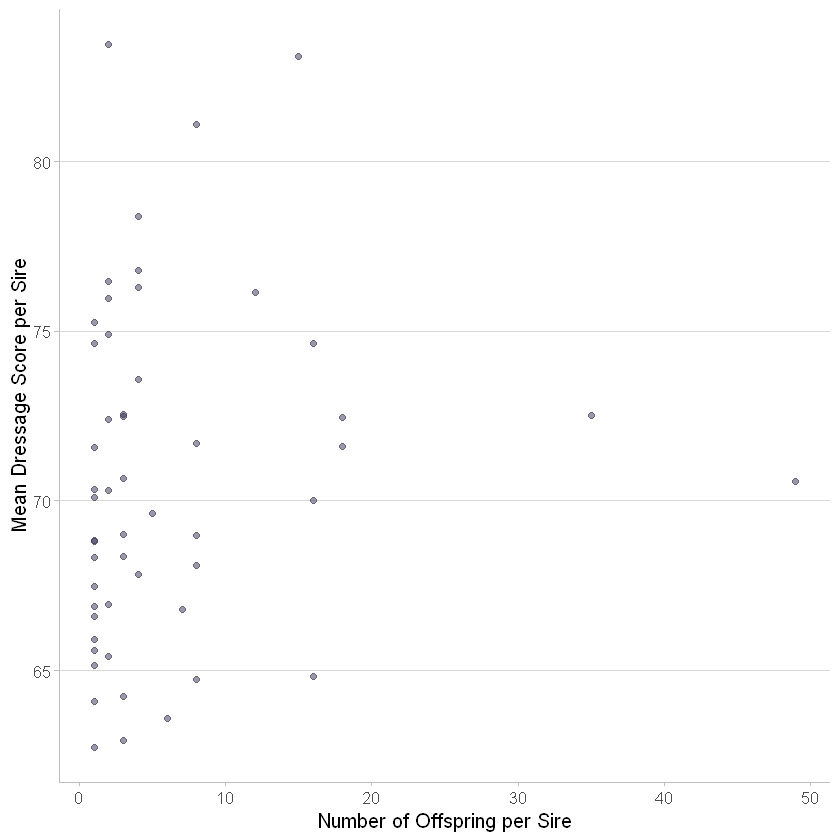

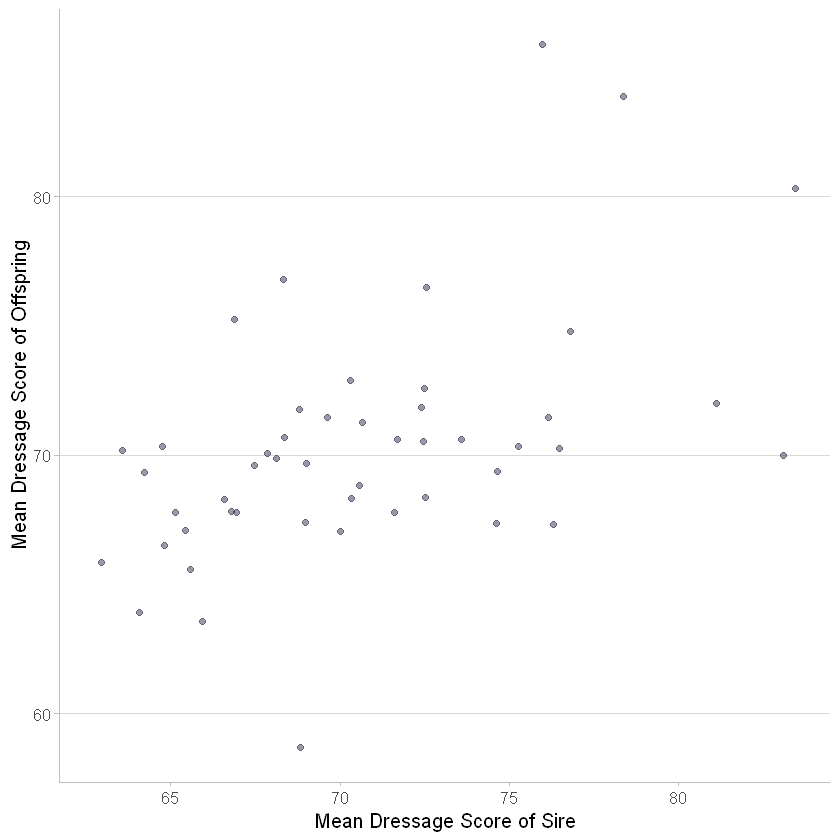

In [79]:
ggplot(aes(x = is_sire, y = mean_score), data = filter(horses, sex == 1)) +
    geom_boxplot() + 
    geom_jitter(alpha = 0.25) + 
    theme_hc() + 
    labs(y = "Mean Score of Horse", x = "Whether the horse has sired other international dressage horses")

ggplot(aes(y = mean_score, x = num_offspring), data = filter(horses, is_sire == 1)) +
  geom_point(color = "#363151", alpha = 0.5) + 
  labs(x = "Number of Offspring per Sire", y = "Mean Dressage Score per Sire") +
  theme_fei()

ggplot(aes(y = off_score, x = mean_score), data = filter(horses, is_sire == 1)) +
  geom_point(color = "#363151", alpha = 0.5) + 
  labs(x = "Mean Dressage Score of Sire", y = "Mean Dressage Score of Offspring") +
  theme_fei()

## Riders

Riders appear to compete in more shows than individual horses, perhaps explaining the fewer instances of extreme mean dressage scores and the higher number of non-completions. 

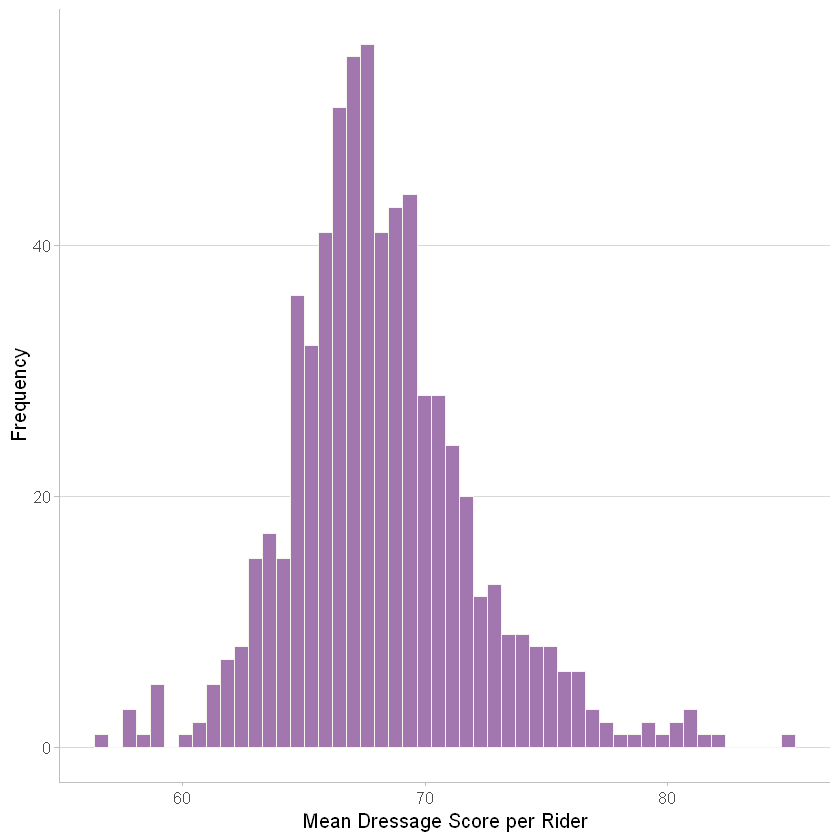

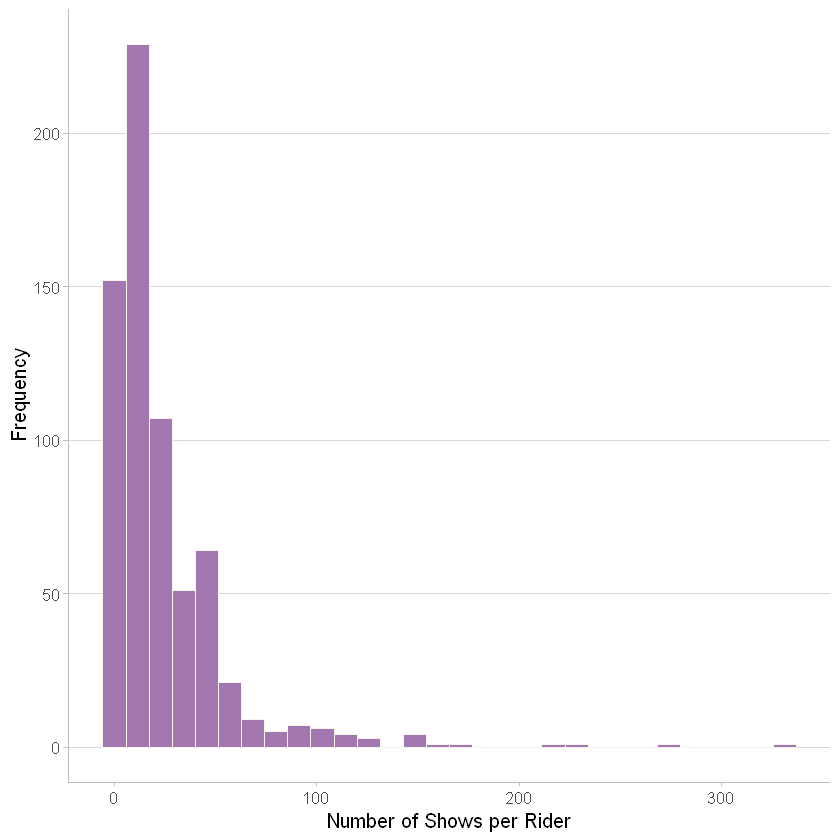

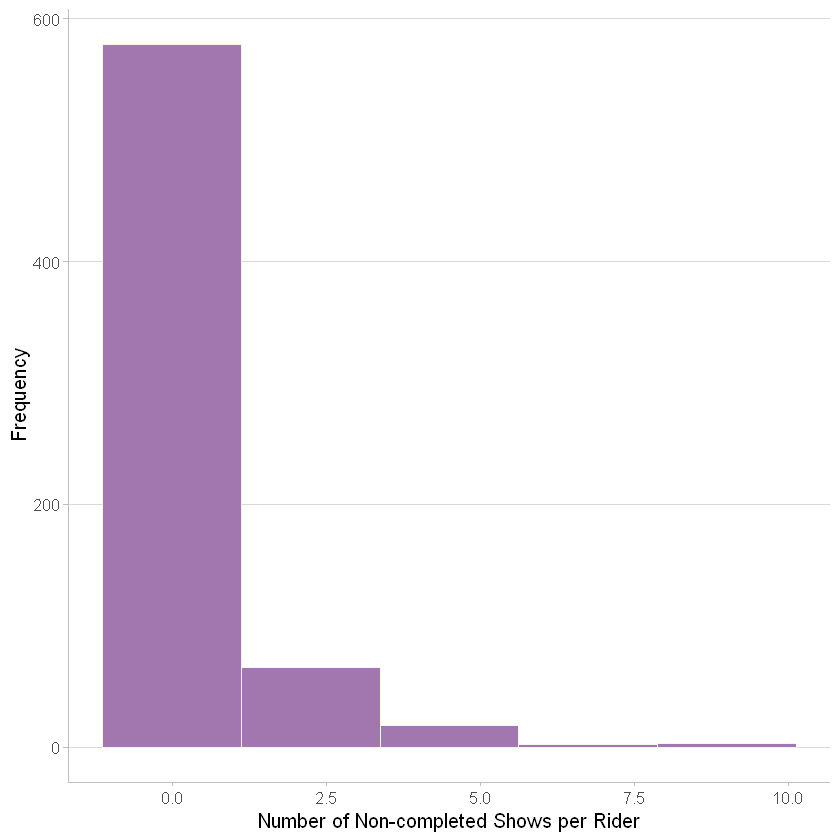

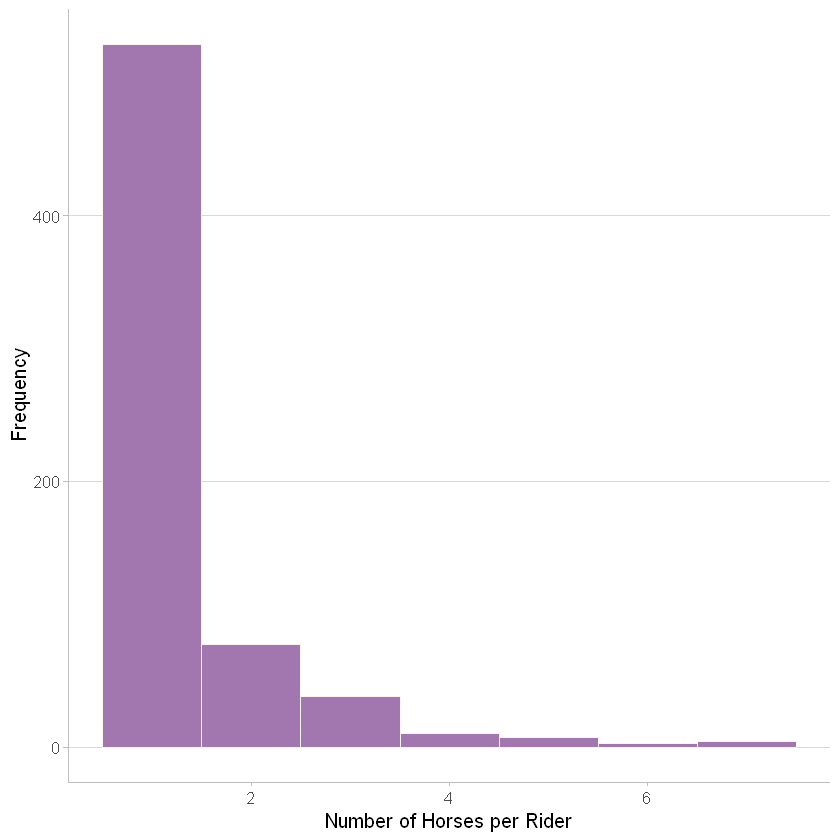

In [80]:
plotHistogram("mean_score", riders, 50, "Mean Dressage Score per Rider")
plotHistogram("num_shows", riders, 30, "Number of Shows per Rider")
plotHistogram("non_comp", riders, 5, "Number of Non-completed Shows per Rider")
plotHistogram("no_horse", riders, 7, "Number of Horses per Rider")

An interesting difference between rider data when compared to combination or horse data is the plot of number of shows against mean score. Although the variance still decreases as number of shows increases, a positive correlation is much more obvious by eye. This is an important finding if I choose to go on to do any modelling: I need to consider how I can model the data so that trends in show number that depend on rider but not on horse, for example, can be accounted for. 

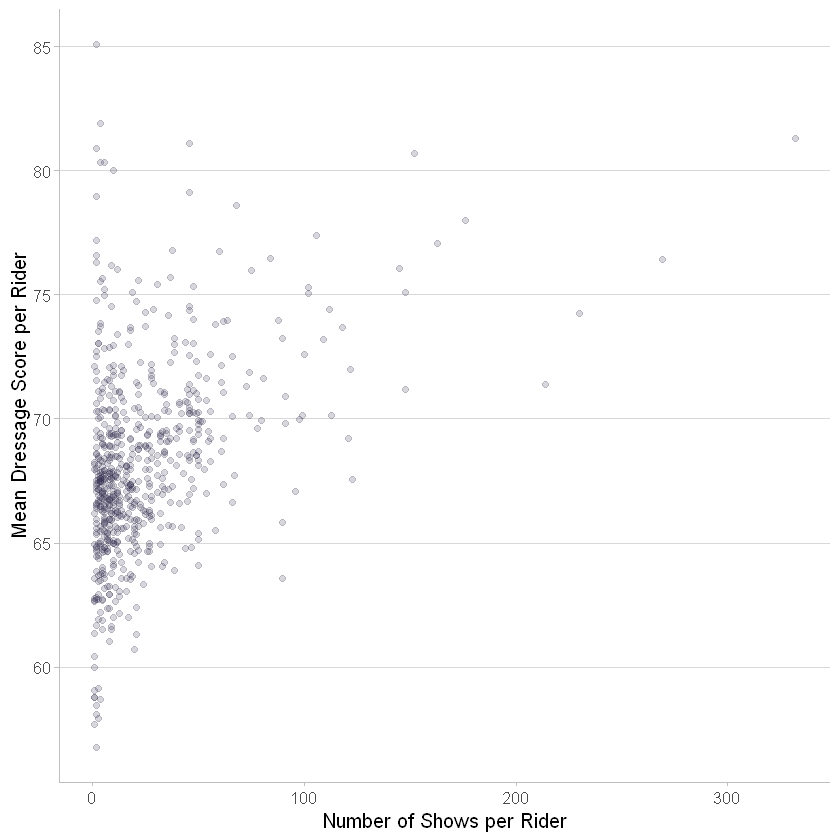

In [81]:
ggplot(aes(y = mean_score, x = num_shows), data = riders) +
  geom_point(color = "#363151", alpha = 0.2) + 
  labs(x = "Number of Shows per Rider", y = "Mean Dressage Score per Rider") +
  theme_fei()

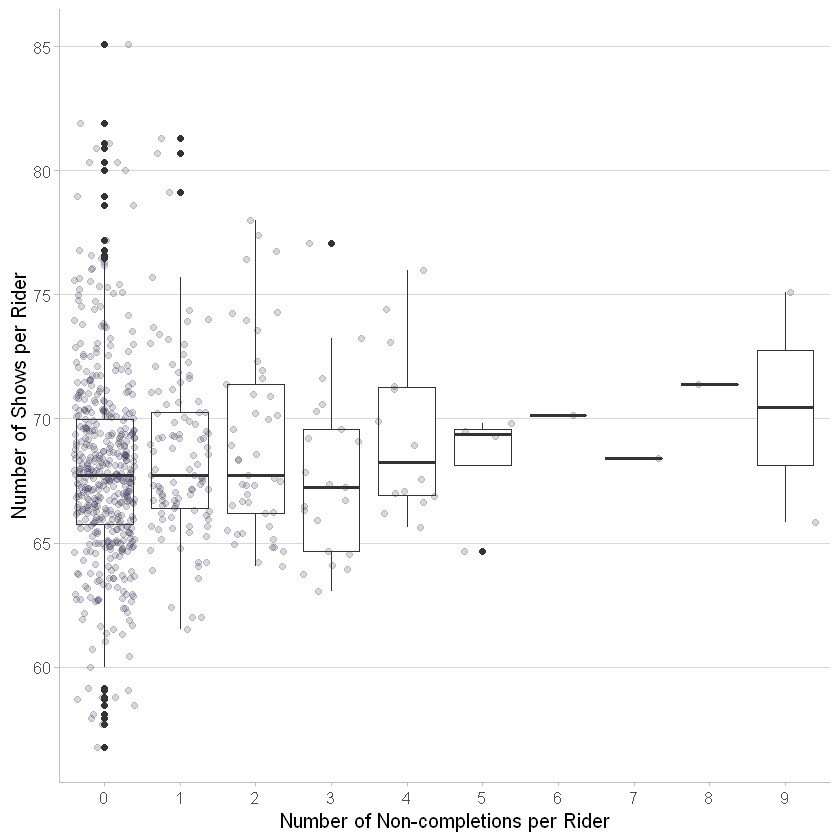

In [82]:
riders[['non_comp']] <- as.factor(riders[['non_comp']])

ggplot(aes(y = mean_score, x = non_comp), data = riders) +
  geom_boxplot() +
  geom_jitter(color = "#363151", alpha = 0.2) + 
  labs(y = "Number of Shows per Rider", x = "Number of Non-completions per Rider") +
  theme_fei()

There does appear to be a trend of increasing mean rider score with the number of horses they have competed on. This might make some sense: successful riders may be more experienced, therefore competed on more horses; or successful individuals may be offered more mounts.

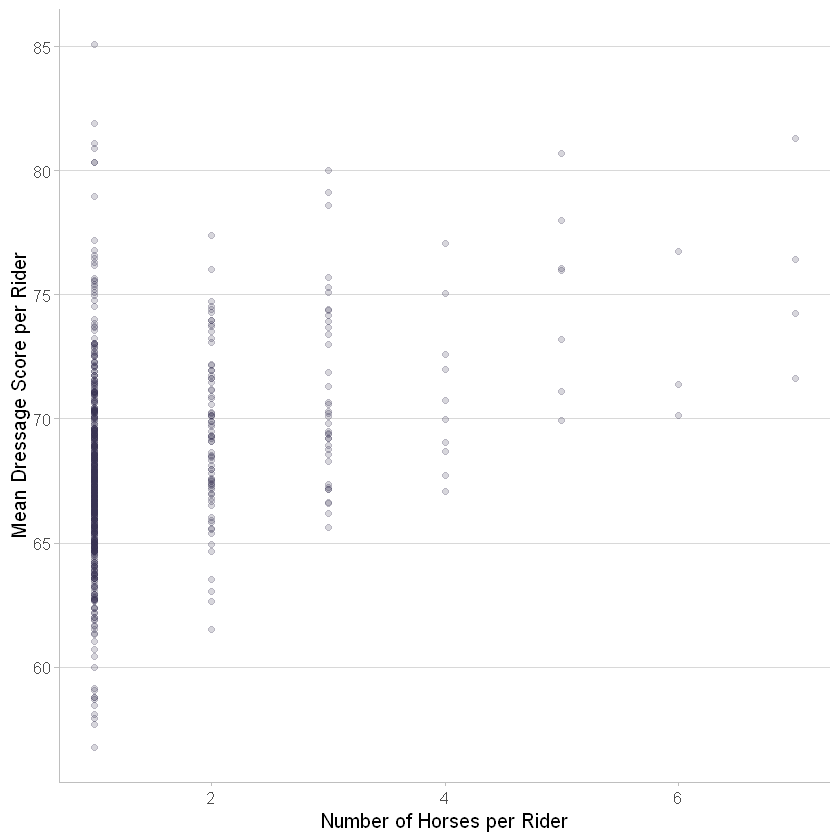

In [83]:
ggplot(aes(y = mean_score, x = no_horse), data = riders) +
  geom_point(color = "#363151", alpha = 0.2) + 
  labs(x = "Number of Horses per Rider", y = "Mean Dressage Score per Rider") +
  theme_fei()

In [84]:
dbWriteTable(conn, "riders", riders, overwrite = T)
dbWriteTable(conn, "horses", horses, overwrite = T)
dbWriteTable(conn, "combinations", combs, overwrite = T)

dbDisconnect(conn)